# scikit-learnのトレーニング♨

## 主成分分析、クラスタ分析 編

## [目次](TableOfContents.ipynb)
- [環境準備](#環境準備)
- [共通的データ処理](#共通的データ処理)
- [モデル・アルゴリズム](#モデル・アルゴリズム)
  - [主成分分析](#主成分分析)
  - [クラスタ分析](#クラスタ分析)

## 参考
開発基盤部会 Wiki
- データマイニング（DM）- Python  
https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E3%83%87%E3%83%BC%E3%82%BF%E3%83%9E%E3%82%A4%E3%83%8B%E3%83%B3%E3%82%B0%EF%BC%88DM%EF%BC%89-%20Python#y4054d35

## [環境準備](ScikitLearnTraining0.ipynb)

In [1]:
import io
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets                                 # サンプル・データセット
from sklearn.datasets import make_regression                 # 回帰データセット作成
from sklearn.datasets import make_blobs                      # 分類データセット作成
from sklearn.preprocessing import StandardScaler             # 標準化
from sklearn.model_selection import train_test_split         # データ分割

from sklearn.linear_model import LinearRegression            # 線形回帰
from sklearn.preprocessing import PolynomialFeatures         # 多項式回帰の変数変換
from sklearn.linear_model import Ridge                       # 多項式回帰のRidge回帰
from sklearn.linear_model import Lasso                       # 多項式回帰のLASSO回帰
from sklearn.linear_model import ElasticNet                  # 多項式回帰のLASSO回帰
from sklearn.linear_model import Perceptron                  # 単純パーセプトロン線形分類器
from sklearn.linear_model import LogisticRegression          # ロジスティク回帰
from sklearn.svm import SVC                                  # サポートベクターマシン（SVM）分類器
from sklearn.tree import DecisionTreeClassifier              # 決定木（分類木）
from sklearn.ensemble import RandomForestClassifier          # ランダムフォレスト（分類木）
from sklearn.ensemble import GradientBoostingClassifier      # 勾配ブースティング木（分類木）
from sklearn.decomposition import PCA                        # 主成分分析
from sklearn.cluster import KMeans                           # k-means法 クラスタ分析
from sklearn.feature_extraction.text import CountVectorizer  # 自然言語処理ベクトル化
from sklearn.feature_extraction.text import TfidfTransformer # 自然言語ベクトルのTF-IDF計算
from sklearn.decomposition import LatentDirichletAllocation  # 自然言語ベクトルからLDAトピック抽出

from sklearn import metrics                                  # モデル評価
from sklearn.metrics import mean_squared_error as mse        # 精度評価（mse）
from sklearn.metrics import confusion_matrix                 # 混同行列
from sklearn.metrics import silhouette_samples               # シルエット係数
from sklearn.model_selection import cross_val_score          # 交差検証法
from sklearn.model_selection import KFold                    # k分割交差検証法
from sklearn.model_selection import StratifiedKFold          # 層化交差検証法
from sklearn.model_selection import GridSearchCV             # グリッドサーチ

import seaborn as sns                                        # matplotlibラッパ
from mlxtend.plotting import plot_decision_regions           # 決定領域表示関数
from matplotlib import cm                                    # カラーマップ処理

from numpy import linalg as LA                               # 線形代数ライブラリ

In [2]:
import warnings
warnings.filterwarnings('ignore')

## 共通的データ処理

### 生成

In [3]:
iris = datasets.load_iris()
df_data = pd.DataFrame(iris.data, columns=iris.feature_names)
df_target = pd.DataFrame(iris.target, columns=['species'])
df = pd.concat([df_data, df_target], axis=1)
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


### 加工
特になし。

### 理解

#### 基本統計量

In [4]:
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


#### 相関

##### カテゴリ分類した散布図行列を表示

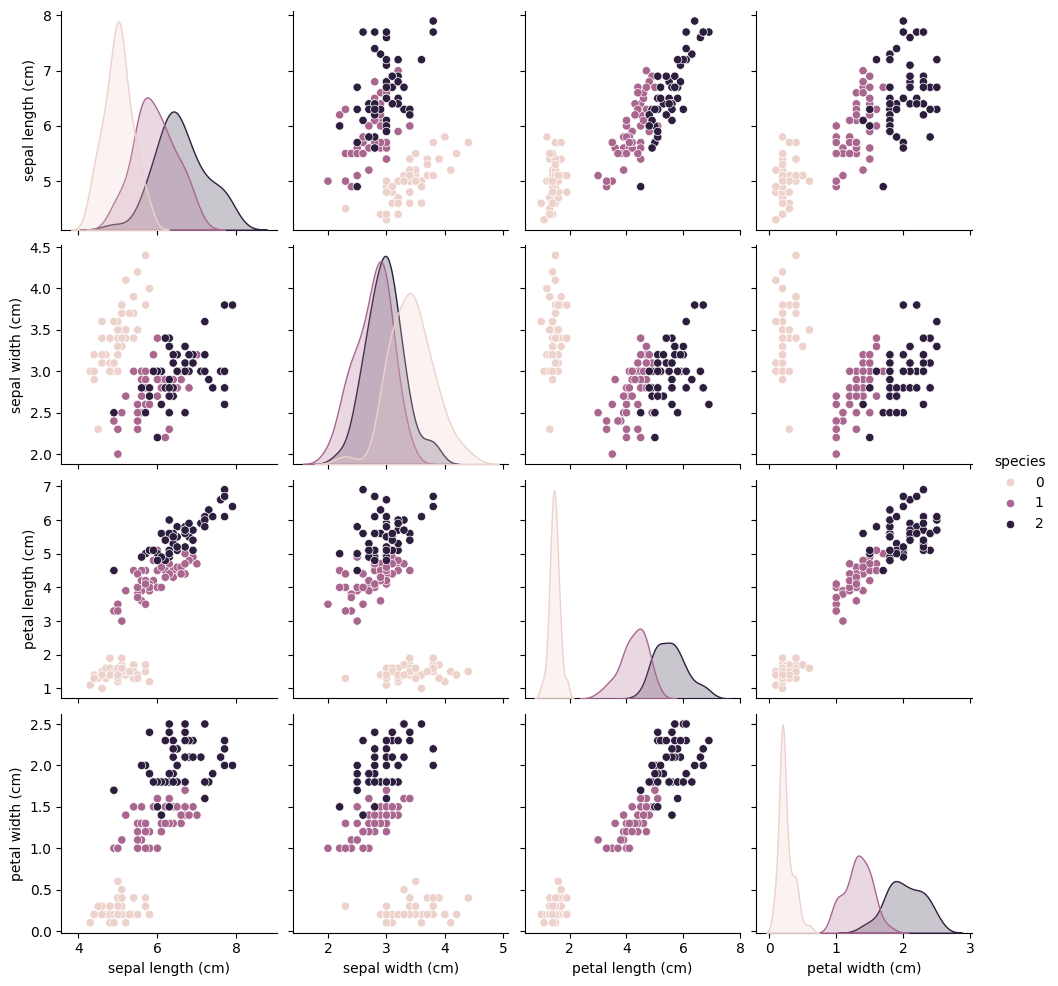

In [5]:
sns.pairplot(df, hue='species')
plt.show()

### 準備

#### 説明変数・目的変数の選択・分割

In [6]:
np_arr=np.array(df)

# n = 100で2値分類
# n = 150で3値分類
n = 150

# PetalLengthCm, PetalWidthCm列の選択
# x=np_arr[:n, 2:4] 

# 全列選択
x=np_arr[:n, 0:4] 

# Species列の選択
y=np.array(np_arr[:n, 4:5],dtype=np.int64) # 要素の型をint64に変換

#### 標準化
カテゴリ・データは対象外

In [7]:
ss = StandardScaler()
ss.fit(x)
x_std = ss.transform(x)

#### 学習・テストデータの分割

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x_std, y, test_size=0.3, random_state=0)

## モデル・アルゴリズム
主成分分析をクラスタ分析と組み合わせ、  
高次の次元で定義されたデータを2次元空間データで表現

### 主成分分析
- データを要約する特徴量（主成分）を抽出する手法
- 数学的には､特徴空間内の座標軸を再設定する手法

※ [イメージ](https://www.google.com/search?q=主成分分析&tbm=isch)、[説明](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E7%B5%B1%E8%A8%88%E8%A7%A3%E6%9E%90#f800acad)

#### [データ](#共通的データ処理)

#### モデリング
- 取得する主成分数は説明変数の数以下に設定。
- 学習だけのアルゴリズム。推論は行わない。

##### 次元削減前

In [9]:
x.shape

(150, 4)

##### 取得する主成分数を指定して学習
パイパーパラメタのn_componentsを指定して学習

In [10]:
pca = PCA(n_components=3) 
x_pca = pca.fit_transform(x_std)

##### 次元削減後

In [11]:
x_pca.shape

(150, 3)

#### 結果（~~評価~~
チューニング要素が主成分数の変更以外なさそうなので評価ではなく結果確認。

##### 可視化

###### 上記を第1、2主成分で散布すると上手く、３値分類されていることが可視化される。

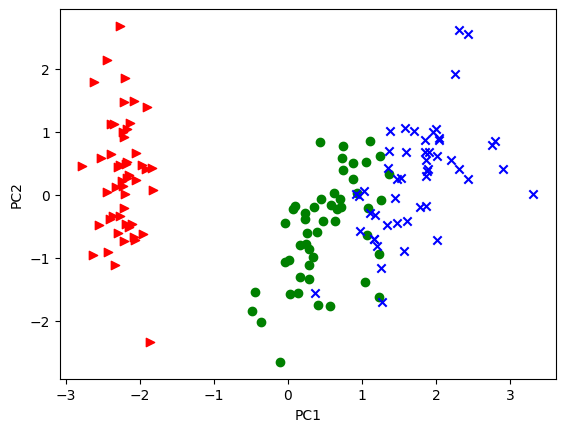

In [12]:
plt.figure()
for target, marker, color in zip(range(3), '>ox', 'rgb'): # ３値分類
    # y==targetで、boolのnumpy.ndarrayベクトルが返るのでコレで行を指定している。
    plt.scatter(x_pca[y.flatten()==target, 0], x_pca[y.flatten()==target, 1], marker=marker, color=color)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

###### 上記を第2、3主成分で散布図にプロットすると上手く、分類されていないことが可視化される。

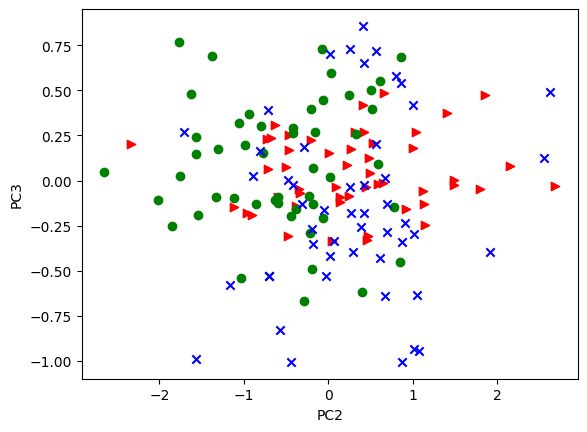

In [13]:
plt.figure()
for target, marker, color in zip(range(3), '>ox', 'rgb'): # ３値分類
    # y==targetで、boolのnumpy.ndarrayベクトルが返るのでコレで行を指定している。
    plt.scatter(x_pca[y.flatten()==target, 1], x_pca[y.flatten()==target, 2], marker=marker, color=color)
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.show()

##### 寄与率

###### 通常の寄与率
固有値を固有値の合計に占める％として表す。

In [14]:
pca.explained_variance_ratio_

array([0.72962445, 0.22850762, 0.03668922])

###### 累積寄与率（合計100%）
主成分に元の情報の何％を残すことができたか情報の集約度
- 寄与率の累積％を表す。一般に、80％が1つの目安になっている。
- いくつの主成分を採用するかは累積寄与率が基準になる。

In [15]:
np.cumsum(pca.explained_variance_ratio_)

array([0.72962445, 0.95813207, 0.99482129])

##### 因子負荷量
- 出力の行列はn行が第n主成分の因子負荷量を表し、
- n列が当該成分の因子負荷量に対する説明変数の相関を表す。

In [16]:
pca.components_ * np.sqrt(pca.explained_variance_)[:, np.newaxis]

array([[ 0.89315091, -0.46168423,  0.99487699,  0.96821173],
       [ 0.3620387 ,  0.88567345,  0.02349363,  0.06421425],
       [ 0.27658115, -0.09393351, -0.05462939, -0.24379667]])

##### 第1、2主成分で分類
[分類器](ScikitLearnTraining4.ipynb)で第1、2主成分を分類してみると良い。

### クラスタ分析
- 似ているサンプル同士をグループ（クラスタ）にまとめる教師なし学習の手法
- 非階層型クラスタリングのk-means法で特徴空間内の距離を使って重心を変えながらクラスタ化する。
- 距離にはユークリッド距離を使うので[主成分分析](#主成分分析)と相性が良い（円形のクラスタリング）。
- 従って、サンプル数の異なるクラスタ、超球状でないクラスタの検出が苦手
- 一方で、マハラノビス距離を用いた場合は、相関関係を考慮できる（楕円形のクラスタリング）

※ [イメージ](https://www.google.com/search?q=k-means%20clustering&tbm=isch)、[説明](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E7%B5%B1%E8%A8%88%E8%A7%A3%E6%9E%90#df844c06)、[K-means 法を D3.js でビジュアライズしてみ
](http://tech.nitoyon.com/ja/blog/2013/11/07/k-means/)

#### データ
[主成分分析](#主成分分析)の結果データを使用する。

#### モデリング
教師なし学習で推論はない。

In [17]:
km = KMeans(n_clusters=3,   # クラスタの個数を指定
            init='random',  # 重心の初期値の決め方を決定
            n_init=10,      # 異なる重心の初期値を用いての実行回数
            max_iter=300,   # ひとつの重心を用いたときの最大イテレーション回数
            tol=1e-04,      # 収束と判定するための相対的な許容誤差
            random_state=0, # 重心の初期化に用いる乱数生成器の状態
           )

y_km = km.fit_predict(x_pca[:, 0:2]) # PC1, 2のみ使用

#### 評価

##### SSE
クラスタ内誤差平方和（SSE）は小さいほどよい。

In [18]:
km.inertia_

115.02075663593985

##### 結果を表示する。

###### 関数定義

In [19]:
def kmeans_plot(n_clusters, km, x):
    # クラスタの予測値を算出
    y_km = km.fit_predict(x)
    
    # クラスタ毎に散布（ZIP的に5クラスまで、要素を増やせば対応可能
    for i, color, marker in zip(range(n_clusters), 'rgbcm', '>o+xv'):
        plt.scatter(x[y_km==i, 0],            # 横軸の値
                    x[y_km==i, 1],            # 縦軸の値
                    color=color,              # プロットの色
                    marker=marker,            # プロットの形
                    label='cluster ' + str(i) # ラベル
                   )
    
    # クラスタの中心を散布
    plt.scatter(km.cluster_centers_[:, 0],    # 横軸の値
                km.cluster_centers_[:, 1],    # 縦軸の値
                color='y',                    # プロットの色
                marker='*',                   # プロットの形
                label='centroids',            # ラベル
                s=300,                        # プロットのサイズを大き目に
               )
   
    plt.legend()
    plt.grid()
    plt.show()

###### 結果をプロット

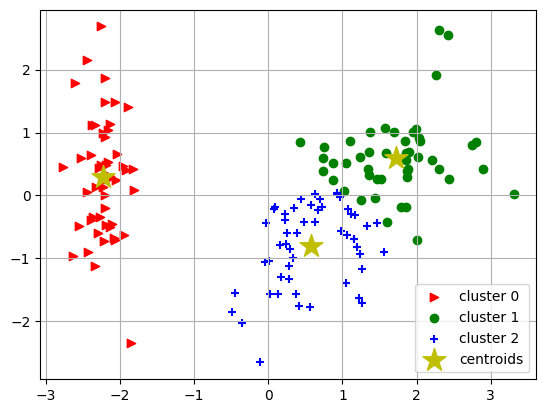

In [20]:
kmeans_plot(3, km, x_pca[:, 0:2]) # PC1, 2のみ使用

##### クラスタリングを分類データで評価
分類データを用いてクラスタリングを正解率を計算する。

###### 関数定義

In [21]:
def kmeans_score(y_km, y):
    y=y.flatten()
    correct_ans = 0
    for i in range(len(y)):
        if y_km[i] == y[i]:
            correct_ans += 1
    return correct_ans / len(y)

###### 結果表示

In [22]:
# クラスタ番号をラベルに一致させる。
y_km[y_km==2]=3
y_km[y_km==1]=2
y_km[y_km==3]=1
# スコアの表示
kmeans_score(y_km, y)

0.8333333333333334

#### 問題と対策

##### 重心の初期値次第で､最終的なクラスタが大きく変わる

- k-means法をk-means++法に変更する。  
  - 初期値の選択方法を改良
    - 異なる重心の初期値を用いての実行回数（n_init）の値を変え繰り返し実行し、
    - クラスタ内誤差平方和（SSE）が一番小さくなった学習器を採用する。
  - 設定方法  
    - init='k-means++'と設定し実行する
    - initの既定値は'k-means++'になっている。

##### クラスタの数を自分で決めなければならない

###### エルボー法
- クラスタ数とクラスタ内誤差平方和（SSE）の関係を見る。
- SSEが小さくてもクラスタ数ムダに多い時は適切でない可能性。
- 以下の例では、肘の部分は 2 - 4 に見え、結構曖昧ではある。

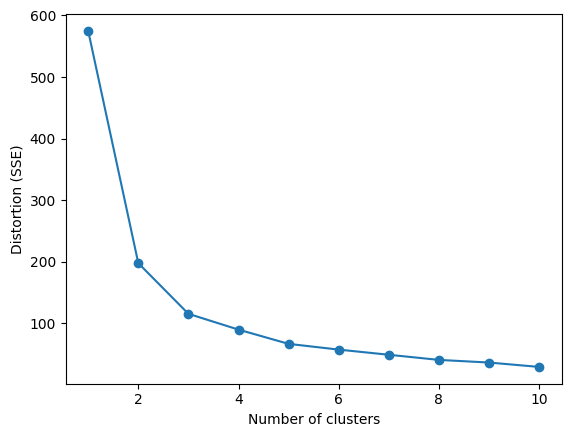

In [23]:
# クラスタ数とSSE
distortions = []
for k  in range(1,11):              # 1~10クラスタ
    km = KMeans(n_clusters=k,       # クラスタ数
                init='random',      # 重心の初期値の決め方を決定
                n_init=10,          # 重心の初期値を変えての繰り返し回数
                max_iter=300,       # 一回の最適化の繰り返し回数を指定
                random_state=0)     # 乱数の生成状態を指定
    km.fit(x_pca[:, 0:2])           # クラスタリングを実行
    distortions.append(km.inertia_) # SSEをリストに格納
    # 良く解らんが、distortion = cluster inertia = SSEらしい。

# 結果をグラフに出力
plt.plot(range(1,11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion (SSE)')
plt.show()

##### クラスタリングの質を判定する必要がある。

###### シルエット分析
- クラスタリングの質を判定
  - 縦軸はサンプル数
  - 横軸はシルエット係数
- 見方：同じ太さのナイフ状のパレートが平均の線に深めに刺さっていると良い感じ。
  - シルエット係数の平均値より大きいサンプルが多いクラスタは適切にクラスタリングされている。
  - 全クラスタのサンプル数が大きく偏っていない場合、適切にクラスタリングされている。

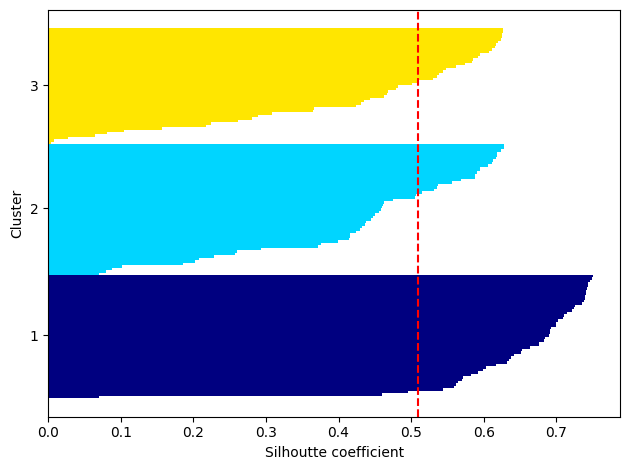

In [24]:
# シルエット係数の計算
silhouettes = silhouette_samples(x_pca[:, 0:2], y_km, metric='euclidean')

# シルエット係数の表示
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]

yticks = []
y_ax_lower, y_ax_upper = 0, 0

for i, cluster_label in enumerate(cluster_labels):
   # 当該クラスタの係数を取り出す
   cluster_silhouettes = silhouettes[y_km==cluster_label]
   # 描画の上端の値を設定
   y_ax_upper += len(cluster_silhouettes)
   # 描画時の色の値をセット
   color = cm.jet(float(i) / n_clusters)
   # クラスタを横棒グラフで描画
   cluster_silhouettes.sort()
   plt.barh(range(y_ax_lower, y_ax_upper), 
            cluster_silhouettes, 
            height=1.0, 
            edgecolor='none', 
            color=color)
   # クラスタのラベル位置を指定
   yticks.append((y_ax_lower + y_ax_upper) / 2.)
   # 次の描画のスタート位置
   y_ax_lower += len(cluster_silhouettes)

plt.axvline(np.mean(silhouettes), color='red', linestyle='--')
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhoutte coefficient')
plt.tight_layout()
plt.show()